# Model

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
rent2_path = '../data/curated/rent.csv'
rent2_df = pd.read_csv(rent2_path)

#rent2_df = rent2_df.drop('Month',axis=1)

# Prepare the feature columns and target
feature_columns = ['Year','Bed', 'Apartment', 'postcode', 'population', 'income', 'Camp', 
                   'Language', 'Primary', 'Secondary', 'Special', 'school_total', 
                   'tram_count', 'bus_count', 'train_count']


target_column = 'Median'

X = rent2_df[feature_columns]
y = rent2_df[target_column]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,     
    max_depth=3,          
    learning_rate=0.05,   
    subsample=0.8,        
    colsample_bytree=0.8  
)


# Train the model on the full training data
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)




In [3]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate R-squared and RMSE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Display the results
print(f"R-squared: {r2}")
print(f"RMSE: {rmse}")


R-squared: 0.8763799667358398
RMSE: 64.50393607349795


/opt/miniconda3/envs/mast30034_env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Feature Importance

<Figure size 1000x800 with 0 Axes>

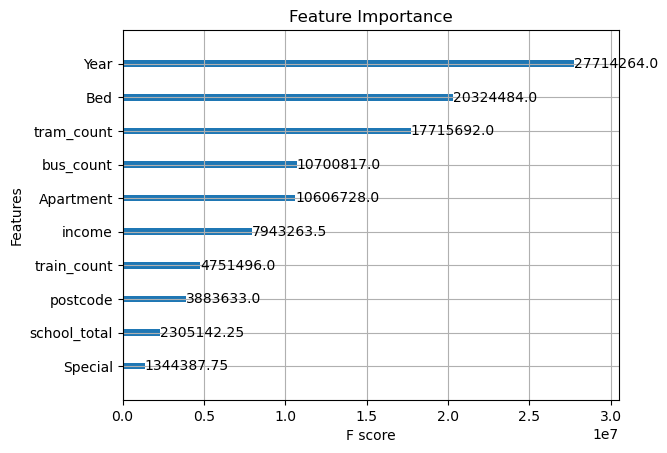

In [4]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, importance_type='gain', max_num_features=10)  # Top 10 features
plt.title('Feature Importance')
plt.show()



# Cross-Validation

In [5]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_rmse = -cross_val_score(model, X, y, cv=5, scoring='neg_root_mean_squared_error')
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)}")

Cross-Validation RMSE: 80.80442166889138


# Learning Curves

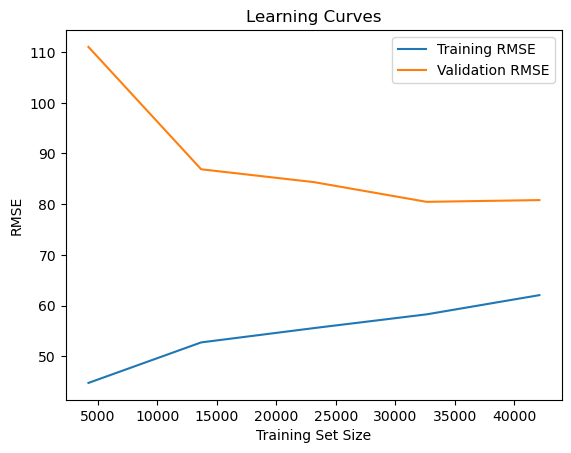

In [6]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, valid_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

plt.plot(train_sizes, -train_scores.mean(axis=1), label='Training RMSE')
plt.plot(train_sizes, -valid_scores.mean(axis=1), label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Residual Analysis on Validation Set

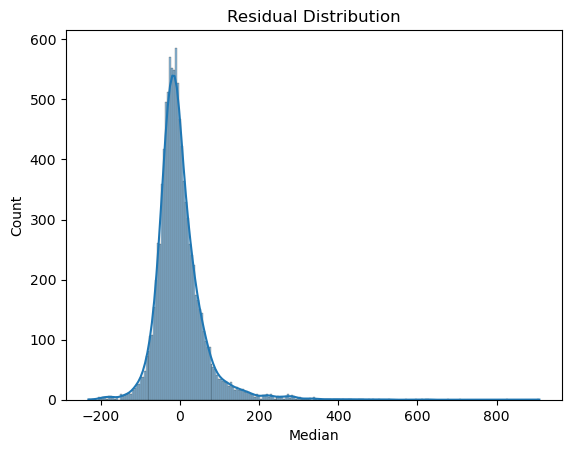

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.show()

# SHAP Value Analysis

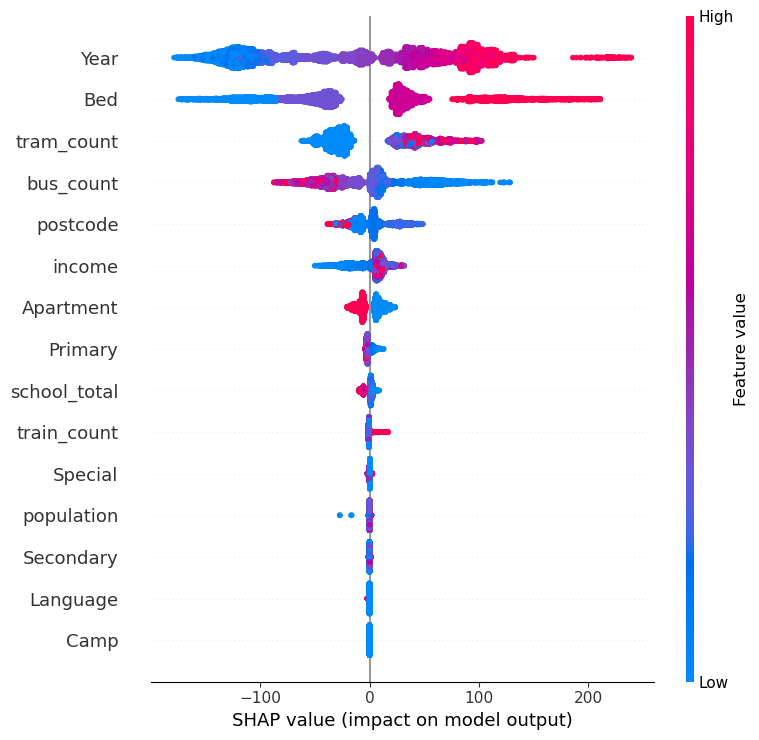

In [8]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

#  Generating Future Predictions (2025-2027)

In [9]:
import pandas as pd
import xgboost as xgb

# Load the rent2 dataset
rent2_path = '../data/curated/rent.csv'
rent2_df = pd.read_csv(rent2_path)

# Drop the 'Month' column as in the previous steps
#rent2_df = rent2_df.drop('Month', axis=1)

# Prepare the feature columns and target column for rent2
feature_columns = ['Year', 'Bed', 'Apartment', 'postcode', 'population', 'income', 'Camp', 
                   'Language', 'Primary', 'Secondary', 'Special', 'school_total', 
                   'tram_count', 'bus_count', 'train_count']

target_column = 'Median'

X_train_full = rent2_df[feature_columns]  # All of rent2 data for training
y_train_full = rent2_df[target_column]

# Load the test3 dataset
test3_path = '../data/curated/test.csv'
test3_df = pd.read_csv(test3_path)

# Prepare the features from test3 (without the target column, since we want to predict)
X_test3 = test3_df[feature_columns]  # The same feature columns used for training

# Create the XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train the model on the entire rent2 dataset
model.fit(X_train_full, y_train_full)

# Predict on the test3 dataset
test3_predictions = model.predict(X_test3)

# Add the predictions to the test3 dataframe
test3_df['Predicted_Median'] = test3_predictions

# Save the predictions to a new CSV file
output_path = '../data/curated/test_with_predictions.csv'
test3_df.to_csv(output_path, index=False)

# Display the first few rows of the test3 dataframe with the predictions
test3_df

,postcode,Year,Bed,Apartment,population,income,Camp,Language,Primary,Secondary,Special,school_total,tram_count,bus_count,train_count,Predicted_Median
0,3206,2025,2,0,0.015159,154278,0,0,3,1,0,4,33,19,0,665.579407
1,3206,2025,3,0,0.015159,154278,0,0,3,1,0,4,33,19,0,858.559631
2,3206,2025,4,0,0.015159,154278,0,0,3,1,0,4,33,19,0,1060.939331
3,3206,2025,1,1,0.015159,154278,0,0,3,1,0,4,33,19,0,494.929260
4,3206,2025,2,1,0.015159,154278,0,0,3,1,0,4,33,19,0,602.079651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575,3750,2027,2,0,0.292229,80949,0,0,4,2,0,6,0,24,0,522.918457
2576,3750,2027,3,0,0.292229,80949,0,0,4,2,0,6,0,24,0,638.883545
2577,3750,2027,4,0,0.292229,80949,0,0,4,2,0,6,0,24,0,747.410522
2578,3750,2027,1,1,0.292229,80949,0,0,4,2,0,6,0,24,0,417.766785


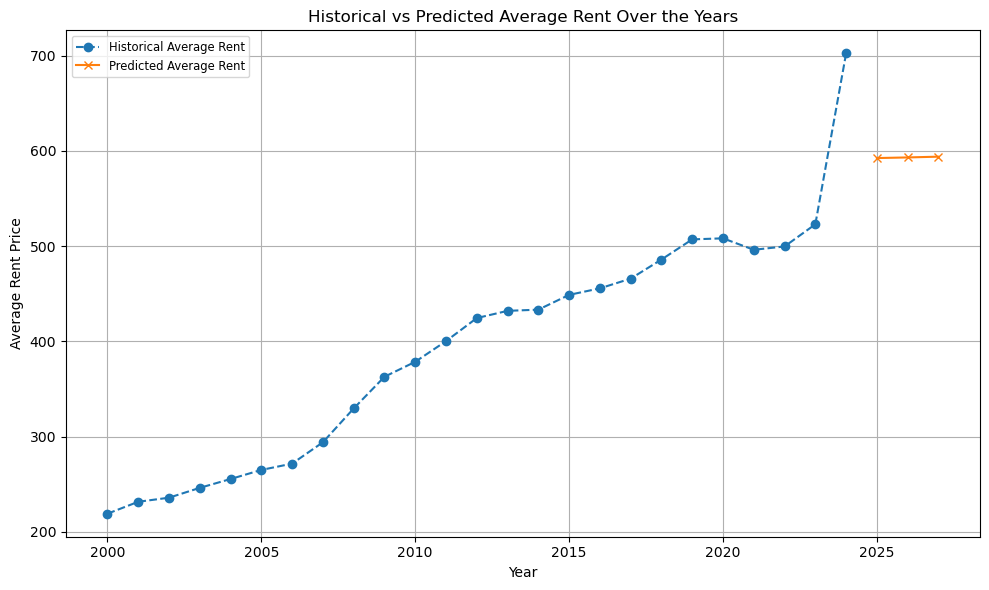

In [12]:
# Group by year and calculate the average rent across all postcodes for both historical and predicted data
average_predicted_rent = test3_df.groupby('Year')['Predicted_Median'].mean().reset_index()
average_historical_rent = rent2_df.groupby('Year')['Median'].mean().reset_index()

# Merge the data to have both historical and predicted in one dataframe
average_rent_data = pd.merge(average_historical_rent, average_predicted_rent, on='Year', how='outer')

# Plot the average rent by year
plt.figure(figsize=(10, 6))
plt.plot(average_rent_data['Year'], average_rent_data['Median'], label='Historical Average Rent', linestyle='--', marker='o')
plt.plot(average_rent_data['Year'], average_rent_data['Predicted_Median'], label='Predicted Average Rent', linestyle='-', marker='x')

plt.title('Historical vs Predicted Average Rent Over the Years')
plt.xlabel('Year')
plt.ylabel('Average Rent Price')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()
